# Color Quantization with Unsupervised Machine Learning (Focus on the label object instead of the background)

Name: Anthony Kevin Oktavius

Recommendation:

If we tend to choose the dataset which pixels focused on the background instead of the object label itself, the result will be more biased to the dominant object, which is the background itself.

So, to mitigate this, instead of finding the most dominant colors, we now try to find the least one.

Install the latest Scikit-Learn version, to use HDBSCAN from scikit-learn.

In [16]:
! pip3 install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Library Import

In [1]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import pickle
import collections

# import pytorch_lightning as pl
import imutils
import zipfile

from wordcloud import WordCloud
from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans, DBSCAN, OPTICS, MiniBatchKMeans, HDBSCAN
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from google.colab.patches import cv2_imshow

Get the dataset

In [2]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d imsparsh/flowers-dataset
! unzip -qq ./flowers-dataset.zip -d ./Dataset

flowers-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./Dataset/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Data Modelling

Added PyTorch transform module to perform some preprocessing steps.

In [2]:
flowers_image_transform = transforms.Compose([
  transforms.Resize((320, 400)),
  transforms.ToTensor(),
])

Use Pytorch to build an imagefolder class to help preparing the dataset.

In [15]:
flowers_image_folder = torchvision.datasets.ImageFolder(
    "/content/Dataset/train",
    transform = flowers_image_transform
)

print(f"Number of classes: {len(flowers_image_folder.classes)}")
print(f"Class names: {flowers_image_folder.classes}")
print(flowers_image_folder[1][1])
flowers_image_folder[1][0].shape

Number of classes: 5
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
0


torch.Size([3, 320, 400])

In [ ]:
class FlowerPerClassDataset(Dataset):
  def __init__(self, image_folder):
    super(FlowerPerClassDataset, self).__init__()
    self.image_folder = image_folder
    self.number_of_classes = len(self.image_folder.classes)

  def __filter_classes_from_image_folder__(self, class_index):
    matched_images = list(
        filter(lambda item: item[1] == class_index, self.image_folder)
    )
    return matched_images

  def __getitem__(self, class_index):
    return self.__filter_classes_from_image_folder__(class_index)

  def __len__(self):
    return self.number_of_classes

flower_per_class_dataset = FlowerPerClassDataset(
    image_folder = flowers_image_folder
)

print(flower_per_class_dataset[0][0])
print(flower_per_class_dataset[0][1])

## Data Visualization

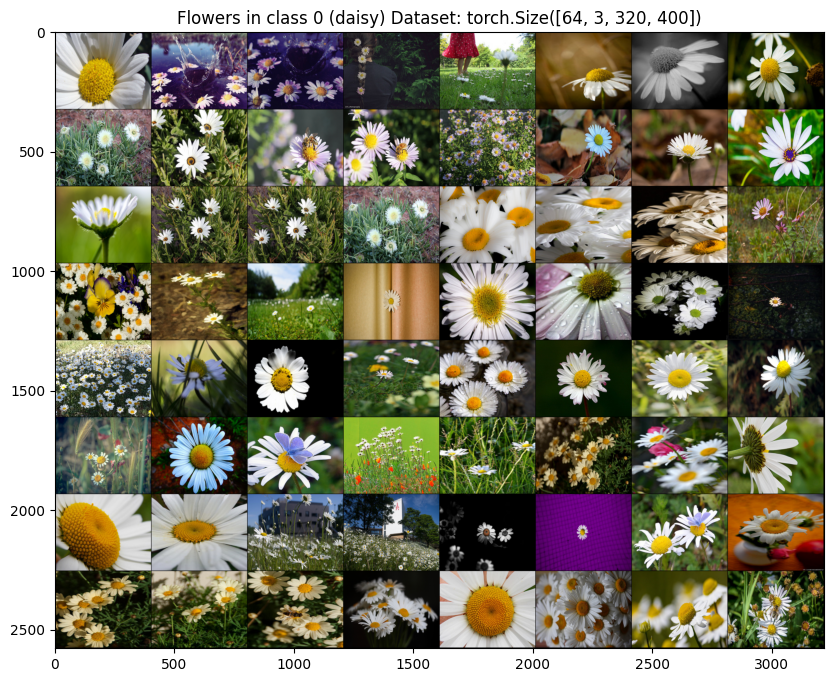

In [19]:
def plot_images_in_grid(title, images, labels, figsize = (5, 5), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = (5, 5))
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_grid(images_in_batch):
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_image_batch, sample_labels_batch = next(iter_loader)

  plt.title(f"{title} Dataset: {sample_image_batch.shape}")
  visualize_grid(sample_image_batch)

flowers_image_loader = torch.utils.data.DataLoader(
    flower_per_class_dataset[0],
    batch_size = 64,
)

plt.figure(figsize = (10, 8))
visualize_dataloader(flowers_image_loader, f"Flowers in class 0 ({flowers_image_folder.classes[0]})")

## Data Modelling

Now, we use unsupervised learning algorithm to determine the dominant colors from the images based on a specific class.

All of the algorithms that we'll implement will perform the same procedures:

* Iterate the images one by one, then performing color quantization with various unsupervised machine learning.

* Get the cluster centers to obtain the core colors from the images.

* In this case, since many images is quite focused on the background, we focus on the unique colors only (by looking at the least dominant colors).

Define main functions to reduce code repetition.

In [ ]:
def flatten_color_images_to_2d_array(images):
  return images.reshape(images.shape[1] * images.shape[2], 3)

def denormalize_image(images):
  RGB_COLOR_RANGE = 255
  images = images * RGB_COLOR_RANGE
  return images

def get_n_dominant_colors_from_images(images, algorithm, rgb_occurence_dict):
  images_reshaped = flatten_color_images_to_2d_array(images)
  images_reshaped = denormalize_image(images_reshaped)
  images_reshaped = images_reshaped.astype(int)
  algorithm.fit(images_reshaped)

  cluster_centers = algorithm.cluster_centers_.astype(int)

  # Determine the most frequent label (color) among all of the pixels given.
  # pixel_labels = k_means.labels_
  # count_pixel_labels = np.unique(pixel_labels, return_counts = True)
  # label_with_most_pixels = np.argmax(count_pixel_labels[1])

  # color_key = cluster_centers[label_with_most_pixels].astype(str)
  # color_key = " ".join(color_key)
  # rgb_occurence_dict[color_key] += 1

  for cluster_center in cluster_centers:
    color_key = cluster_center.astype(str)
    color_key = " ".join(color_key)
    rgb_occurence_dict[color_key] += 1

  return rgb_occurence_dict

def get_n_dominant_colors_from_images(images, algorithm, rgb_occurence_dict):
  images_reshaped = flatten_color_images_to_2d_array(images)
  images_reshaped = denormalize_image(images_reshaped)
  images_reshaped = images_reshaped.astype(int)
  algorithm.fit(images_reshaped)

  cluster_centers = algorithm.cluster_centers_.astype(int)

  # Determine the most frequent label (color) among all of the pixels given.
  # pixel_labels = k_means.labels_
  # count_pixel_labels = np.unique(pixel_labels, return_counts = True)
  # label_with_most_pixels = np.argmax(count_pixel_labels[1])

  # color_key = cluster_centers[label_with_most_pixels].astype(str)
  # color_key = " ".join(color_key)
  # rgb_occurence_dict[color_key] += 1

  for cluster_center in cluster_centers:
    color_key = cluster_center.astype(str)
    color_key = " ".join(color_key)
    rgb_occurence_dict[color_key] += 1

  return rgb_occurence_dict

def get_n_dominant_colors_from_images_non_kmeans(images, algorithm, rgb_occurence_dict):
  images_reshaped = flatten_color_images_to_2d_array(images)
  images_reshaped = denormalize_image(images_reshaped)
  images_reshaped = images_reshaped.astype(int)
  algorithm.fit(images_reshaped)

  components = algorithm.centroids_.astype(int)

  for component in components:
    color_key = component.astype(str)
    color_key = " ".join(color_key)
    rgb_occurence_dict[color_key] += 1

  return rgb_occurence_dict

def ascending_sort_values_dict(dictionary):
  return (
    list(
      sorted(dictionary.items(), key = lambda item: item[1])
    )
  )

def split_by_space(key_value):
  color_name, number_of_occurences = key_value
  return np.array(color_name.split(" ")), number_of_occurences

def plot_colors(colors, number_of_occurences, bar_size):
  bar = np.zeros(bar_size, dtype = "uint8")

  right_step_size = bar_size[1] / len(colors)

  x_start = 0
  for color, number_of_occurences in zip(colors, number_of_occurences):
    x_end = x_start + right_step_size
    cv2.rectangle(bar, (int(x_start), 0), (int(x_end), bar_size[0]), color.astype(int).tolist(), -1)
    x_start = x_end

  cv2_imshow(bar)

def get_list_from_dict_by_index(dictionary, index):
  return list(zip(*dictionary))[index]

### K-Means

In [ ]:
rgb_occurence_dict = defaultdict(int)

MAX_COLORS = 10
class_index = 0
for image_per_class, _ in flower_per_class_dataset[class_index]:
  image_np = image_per_class.numpy()
  k_means = KMeans(n_clusters = MAX_COLORS, n_init = 'auto')
  rgb_occurence_dict = get_n_dominant_colors_from_images(
      image_np,
      k_means,
      rgb_occurence_dict,
  )

In [ ]:
print(list(rgb_occurence_dict[:30]))

In [ ]:
rgb_occurence_ordered_dict = ascending_sort_values_dict(rgb_occurence_dict)

rgb_occurence_ordered_dict.reverse()

rgb_occurence_ordered_dict = list(map(
    split_by_space, rgb_occurence_ordered_dict
))

print("Top 10 most occurence colors in the entire dataset:")
print(rgb_occurence_ordered_dict[:30])
print(f"Length of the dictionary: {len(rgb_occurence_ordered_dict)}")

Top 10 most occurence colors in the entire dataset:
[(array(['4', '4', '4'], dtype='<U1'), 28), (array(['3', '3', '3'], dtype='<U1'), 26), (array(['2', '2', '2'], dtype='<U1'), 21), (array(['5', '5', '5'], dtype='<U1'), 21), (array(['7', '7', '7'], dtype='<U1'), 20), (array(['0', '0', '0'], dtype='<U1'), 16), (array(['36', '36', '36'], dtype='<U2'), 14), (array(['22', '22', '22'], dtype='<U2'), 13), (array(['19', '18', '19'], dtype='<U2'), 13), (array(['237', '238', '237'], dtype='<U3'), 13), (array(['50', '49', '50'], dtype='<U2'), 13), (array(['39', '38', '39'], dtype='<U2'), 12), (array(['61', '61', '61'], dtype='<U2'), 12), (array(['20', '20', '20'], dtype='<U2'), 12), (array(['10', '10', '10'], dtype='<U2'), 12), (array(['8', '8', '8'], dtype='<U1'), 12), (array(['5', '4', '5'], dtype='<U1'), 12), (array(['111', '111', '111'], dtype='<U3'), 11), (array(['1', '1', '1'], dtype='<U1'), 11), (array(['77', '77', '77'], dtype='<U2'), 11), (array(['233', '234', '233'], dtype='<U3'), 11),

Colors with most occurence: 


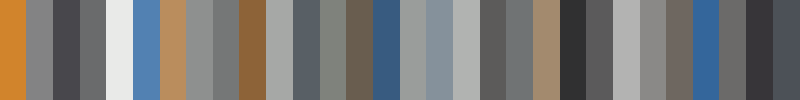

In [ ]:
TOP_N_COLORS = 30
color_names = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 0) # list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 1) # list(zip(*rgb_occurence_ordered_dict))[1]

color_names = list(reversed(color_names))[:TOP_N_COLORS]
number_of_occurences = list(reversed(number_of_occurences))[:TOP_N_COLORS]

bar_size = (100, 800, 3)

color_names = np.array(color_names)
number_of_occurences = np.array(number_of_occurences)

print("Colors with most occurence: ")
plot_colors(color_names, number_of_occurences, bar_size)

### Mini Batch K Means.

Alternative K Means version that uses mini-batch to reduce computation time, but have closer result to objective function (original k means).

Given randomly picked number of samples to form a mini batch, update a centroid. However, update is based on a per-sample basis.

In [9]:
rgb_occurence_dict = defaultdict(int)

class_index = 0
MAX_COLORS = 10

for image_per_class, _ in flower_per_class_dataset[class_index]:
  image_np = image_per_class.numpy()
  mini_batch_k_means =  MiniBatchKMeans(n_clusters = MAX_COLORS, n_init = 'auto')
  rgb_occurence_dict = get_n_dominant_colors_from_images(
      image_np,
      mini_batch_k_means,
      rgb_occurence_dict,
  )

In [17]:
print(list(rgb_occurence_dict)[:30])

['116 116 117', '233 233 233', '37 35 37', '153 156 157', '137 136 135', '10 9 10', '88 85 88', '175 174 172', '188 190 189', '210 211 209', '142 146 147', '18 17 17', '68 65 66', '212 214 208', '114 115 117', '43 42 43', '172 123 74', '178 180 178', '90 90 92', '236 238 237', '93 88 84', '27 27 27', '167 168 166', '143 144 141', '116 117 115', '66 63 62', '48 93 139', '12 12 12', '44 44 45', '190 193 190']


In [15]:
rgb_occurence_ordered_dict = ascending_sort_values_dict(rgb_occurence_dict)

rgb_occurence_ordered_dict.reverse()

rgb_occurence_ordered_dict = list(map(
    split_by_space, rgb_occurence_ordered_dict
))

print("Top 10 most occurence colors in the entire dataset:")
print(rgb_occurence_ordered_dict[:30])
print(f"Length of the dictionary: {len(rgb_occurence_ordered_dict)}")

Top 10 most occurence colors in the entire dataset:
[(array(['3', '3', '3'], dtype='<U1'), 22), (array(['4', '4', '4'], dtype='<U1'), 22), (array(['5', '5', '5'], dtype='<U1'), 18), (array(['0', '0', '0'], dtype='<U1'), 18), (array(['1', '1', '1'], dtype='<U1'), 18), (array(['6', '6', '6'], dtype='<U1'), 16), (array(['9', '8', '9'], dtype='<U1'), 15), (array(['2', '2', '2'], dtype='<U1'), 15), (array(['25', '24', '25'], dtype='<U2'), 13), (array(['8', '8', '8'], dtype='<U1'), 13), (array(['5', '4', '5'], dtype='<U1'), 13), (array(['11', '11', '11'], dtype='<U2'), 13), (array(['7', '7', '7'], dtype='<U1'), 12), (array(['19', '19', '19'], dtype='<U2'), 12), (array(['35', '34', '35'], dtype='<U2'), 11), (array(['15', '15', '15'], dtype='<U2'), 11), (array(['10', '10', '10'], dtype='<U2'), 11), (array(['30', '30', '30'], dtype='<U2'), 11), (array(['4', '3', '4'], dtype='<U1'), 11), (array(['17', '17', '17'], dtype='<U2'), 11), (array(['13', '12', '13'], dtype='<U2'), 10), (array(['229', '2

Colors with most unique occurences: 


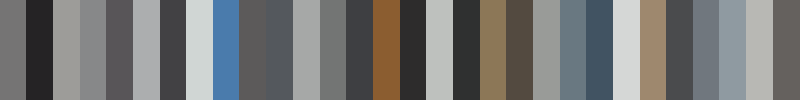

Colors with most occurences:


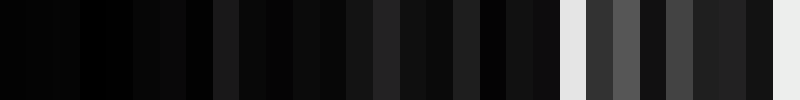

In [26]:
TOP_N_COLORS = 30
bar_size = (100, 800, 3)

# Colors with the most unique occurences (least dominant colors)
color_names = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 0) # list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 1) # list(zip(*rgb_occurence_ordered_dict))[1]
color_names = list(reversed(color_names))[:TOP_N_COLORS]
number_of_occurences = list(reversed(number_of_occurences))[:TOP_N_COLORS]

print("Colors with most unique occurences: ")
plot_colors(color_names, number_of_occurences, bar_size)

# Colors with most occurences (dominant colors)
color_names = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 0) # list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 1) # list(zip(*rgb_occurence_ordered_dict))[1]
color_names = list(color_names)[:TOP_N_COLORS]
number_of_occurences = list(number_of_occurences)[:TOP_N_COLORS]

print("Colors with most occurences:")
plot_colors(color_names, number_of_occurences, bar_size)

### HDBSCAN

Unlike K Means where we define the number of clusters, we use n_samples to determine the number of samples for a point. In other words, if a sample meets n_samples given a specified range, it'll be defined as a point, which belongs to a specific label.

In [10]:
rgb_occurence_dict = defaultdict(int)

class_index = 0
NUMBER_OF_SAMPLES = 10
MINIMAL_NUMBER_OF_SAMPLES_IN_A_CLUSTER = 10

dbscan = HDBSCAN(min_cluster_size = MINIMAL_NUMBER_OF_SAMPLES_IN_A_CLUSTER,
                store_centers = "centroid",
                 min_samples = NUMBER_OF_SAMPLES)
for image_per_class, _ in flower_per_class_dataset[class_index]:
  image_np = image_per_class.numpy()

  rgb_occurence_dict = get_n_dominant_colors_from_images_non_kmeans(
      image_np,
      dbscan,
      rgb_occurence_dict,
  )

KeyboardInterrupt: ignored

In [11]:
print(list(rgb_occurence_dict)[:30])

['18 18 229', '71 71 231', '38 230 229', '17 145 145', '17 17 144', '25 52 126', '145 131 36', '143 150 70', '163 103 41', '118 75 35', '135 40 21', '154 76 22', '154 119 73', '136 113 75', '174 177 228', '176 227 227', '60 25 22', '208 174 146', '215 193 158', '186 168 140', '87 77 64', '173 194 210', '220 211 185', '141 164 180', '169 154 140', '43 51 58', '196 184 168', '129 144 162', '121 129 144', '35 40 45']


In [12]:
rgb_occurence_ordered_dict = ascending_sort_values_dict(rgb_occurence_dict)

rgb_occurence_ordered_dict.reverse()

rgb_occurence_ordered_dict = list(map(
    split_by_space, rgb_occurence_ordered_dict
))

print("Top 10 most occurence colors in the entire dataset:")
print(rgb_occurence_ordered_dict[:30])
print(f"Length of the dictionary: {len(rgb_occurence_ordered_dict)}")

Top 10 most occurence colors in the entire dataset:
[(array(['18', '19', '19'], dtype='<U2'), 6), (array(['20', '21', '23'], dtype='<U2'), 6), (array(['43', '42', '41'], dtype='<U2'), 6), (array(['62', '62', '63'], dtype='<U2'), 5), (array(['43', '44', '45'], dtype='<U2'), 5), (array(['42', '43', '43'], dtype='<U2'), 5), (array(['40', '40', '39'], dtype='<U2'), 5), (array(['46', '47', '48'], dtype='<U2'), 5), (array(['55', '54', '52'], dtype='<U2'), 5), (array(['34', '34', '34'], dtype='<U2'), 5), (array(['33', '32', '32'], dtype='<U2'), 5), (array(['36', '36', '35'], dtype='<U2'), 5), (array(['30', '31', '32'], dtype='<U2'), 5), (array(['31', '32', '32'], dtype='<U2'), 5), (array(['27', '27', '27'], dtype='<U2'), 5), (array(['24', '23', '22'], dtype='<U2'), 5), (array(['23', '23', '24'], dtype='<U2'), 5), (array(['15', '15', '15'], dtype='<U2'), 5), (array(['69', '70', '70'], dtype='<U2'), 5), (array(['18', '18', '17'], dtype='<U2'), 5), (array(['18', '17', '17'], dtype='<U2'), 5), (a

Colors with most unique occurences: 


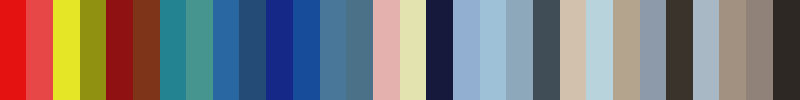

Colors with most occurences:


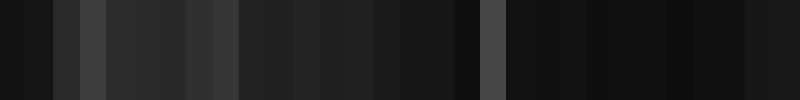

In [13]:
TOP_N_COLORS = 30
bar_size = (100, 800, 3)

# Colors with the most unique occurences (least dominant colors)
color_names = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 0) # list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 1) # list(zip(*rgb_occurence_ordered_dict))[1]
color_names = list(reversed(color_names))[:TOP_N_COLORS]
number_of_occurences = list(reversed(number_of_occurences))[:TOP_N_COLORS]

print("Colors with most unique occurences: ")
plot_colors(color_names, number_of_occurences, bar_size)

# Colors with most occurences (dominant colors)
color_names = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 0) # list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = get_list_from_dict_by_index(rgb_occurence_ordered_dict, 1) # list(zip(*rgb_occurence_ordered_dict))[1]
color_names = list(color_names)[:TOP_N_COLORS]
number_of_occurences = list(number_of_occurences)[:TOP_N_COLORS]

print("Colors with most occurences:")
plot_colors(color_names, number_of_occurences, bar_size)